Tutorial 6: Lens Modeling
=========================

When modeling complex source's with parametric profiles, we quickly entered a regime where our `NonLinearSearch` was
faced with a parameter space of dimensionality N=30+ parameters. This made the model-fitting inefficient, and very
likely to infer a local maxima.

Because `Inversion`'s are linear, they don't suffer this problelm, making them a very a powerful tool for modeling
strong lenses. Furthermore, they have *more* freemdom than paramwtric profiles, not relying on specific analytic
light distributions and symmetric profile shapes, allowing us to fit more complex mass models and ask ever more
interesting scientific questions!

However, `Inversion` have some short comings that we need to be aware of before we begin using them for lens modeling.
That`s what we are going to cover in this tutorial.

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


we'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's total mass distribution is an `EllipticalIsothermal` and `ExternalShear`.
 - The source galaxy's `LightProfile` is an `EllipticalSersic`.

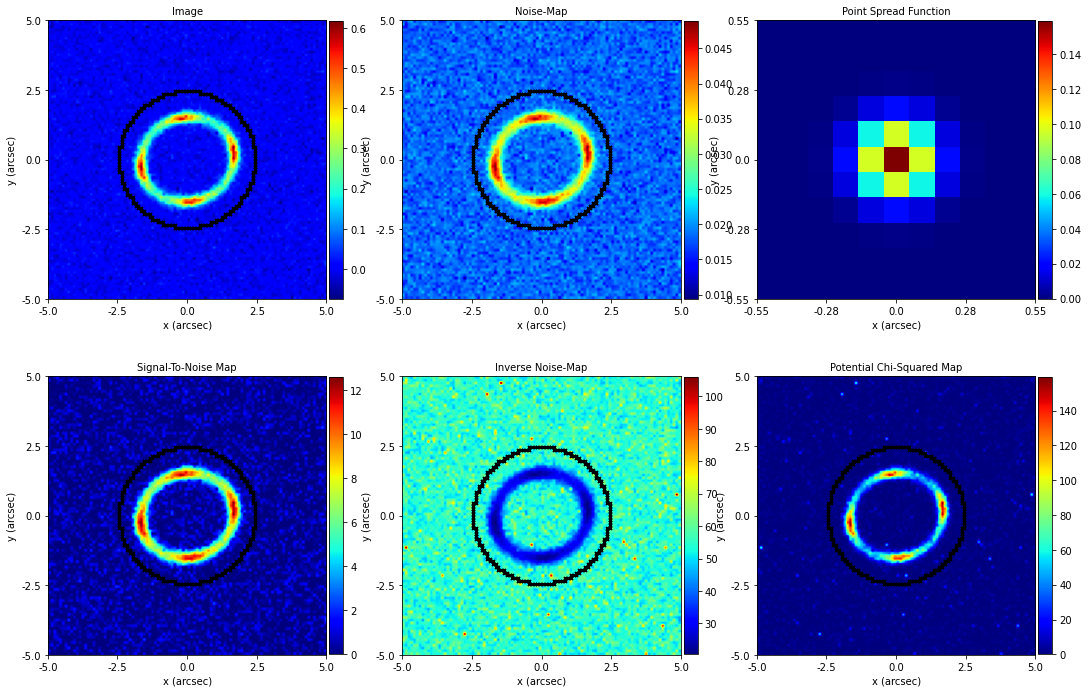

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=2.5,
)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

This function fits the `Imaging` data with a `Tracer`, returning a `FitImaging` object.

In [3]:


def perform_fit_with_lens__source_galaxy(imaging, lens_galaxy, source_galaxy):

    mask = al.Mask2D.circular_annular(
        shape_native=imaging.shape_native,
        pixel_scales=imaging.pixel_scales,
        sub_size=1,
        inner_radius=0.5,
        outer_radius=2.2,
    )

    masked_imaging = al.MaskedImaging(
        imaging=imaging, mask=mask, settings=al.SettingsMaskedImaging(sub_size=1)
    )

    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

    return al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)


To see the short-comings of an `Inversion`, we begin by performing a fit where the lens galaxy has an incorrect 
mass-model (I've reduced its Einstein Radius from 1.6 to 0.8). This is the sort of mass moddel the non-linear search
might sample at the beginning of a model-fit.

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'slim_indexes' of function 'furthest_grid_2d_slim_index_from'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../PyAutoArray/autoarray/structures/grids/two_d/grid_2d_util.py", line 673:
@decorator_util.jit()
def furthest_grid_2d_slim_index_from(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


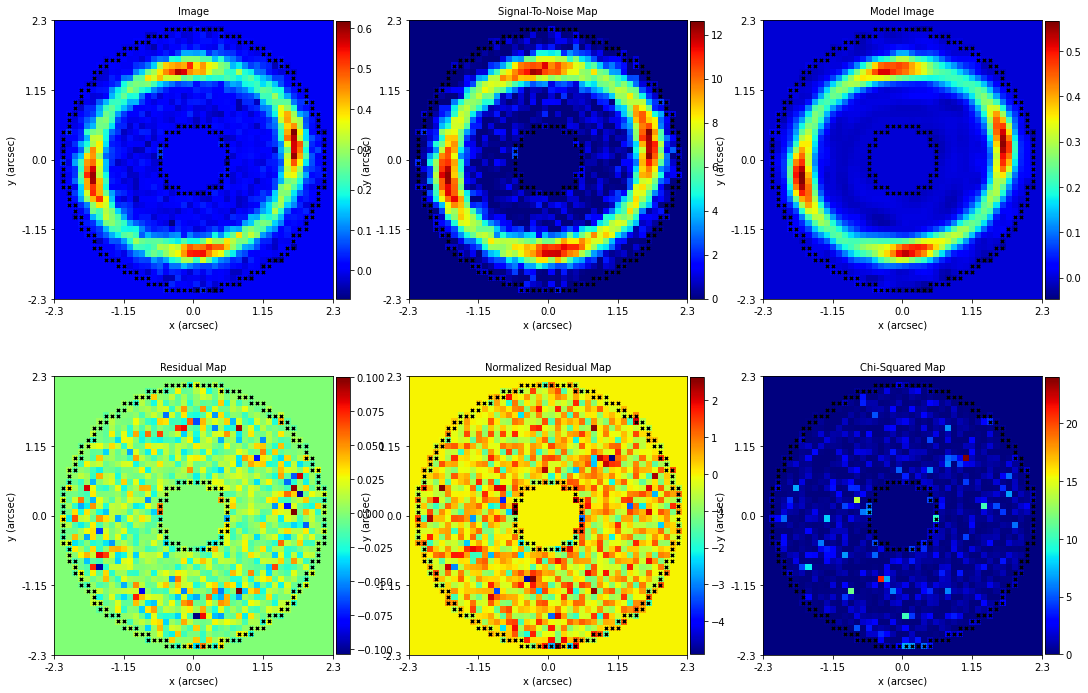

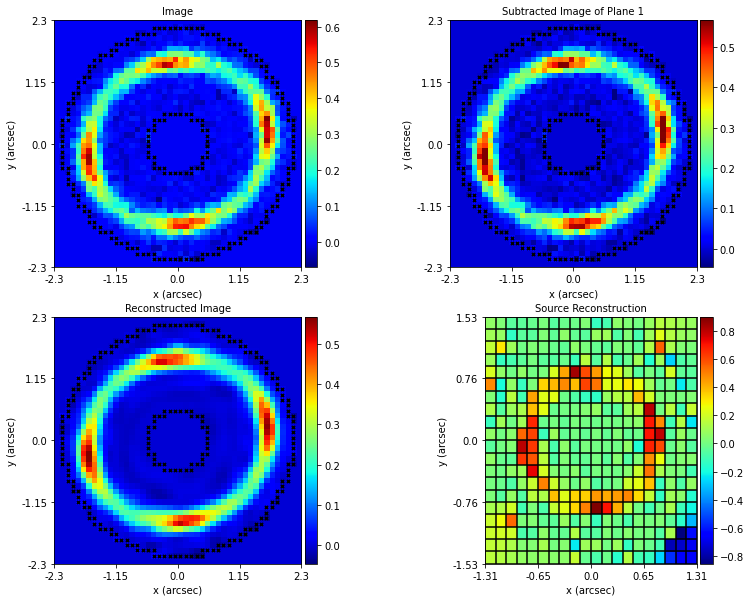

In [4]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=0.8,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, phi=45.0),
    ),
    shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.05)),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(20, 20)),
    regularization=al.reg.Constant(coefficient=1.0),
)

fit = perform_fit_with_lens__source_galaxy(
    imaging=imaging, lens_galaxy=lens_galaxy, source_galaxy=source_galaxy
)

include_2d = aplt.Include2D(mask=True)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.subplot_of_planes(plane_index=1)

What happened!? This incorrect mass-model provides a really good_fit to the image! The residuals and chi-squared-map 
are as good as the ones we saw in the last tutorial.

How can an incorrect lens model provide such a fit? Well, as I'm sure you noticed, the source has been reconstructed 
as a demagnified version of the image. Clearly, this isn't a physical solution or a solution that we want our 
non-linear search to find, but for `Inversion`'s these solutions are real; they exist.

This isn't necessarily problematic for lens modeling. Afterall, the source reconstruction above is extremely complex, 
in that it requires a lot of pixels to fit the image accurately. Indeed, its Bayesian log evidence is much lower than 
the correct solution.

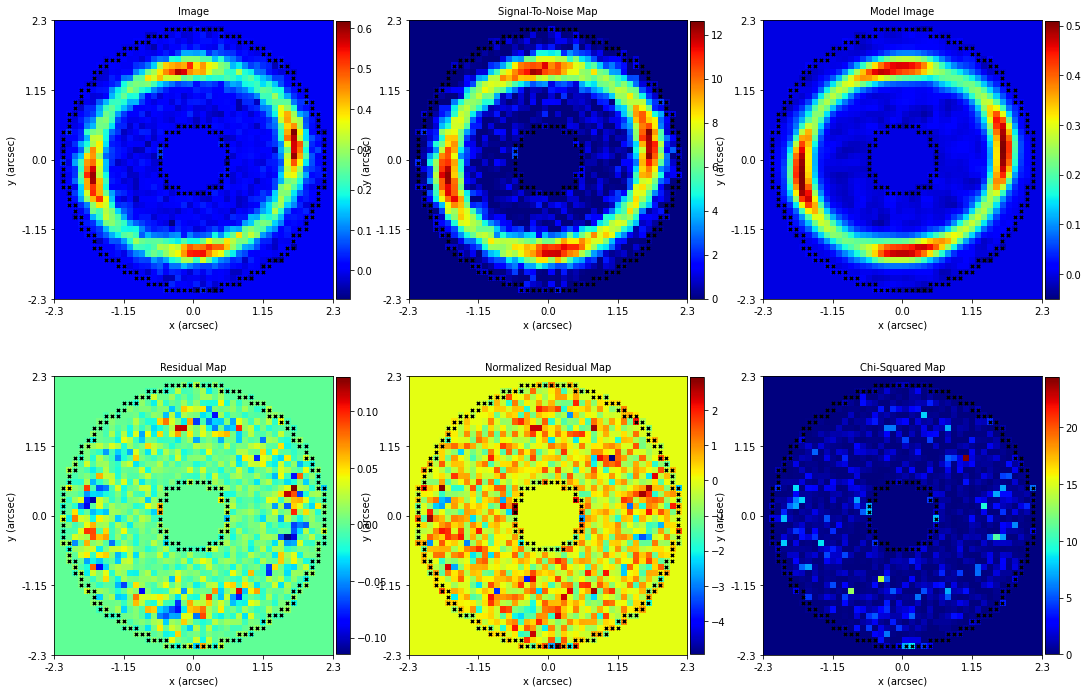

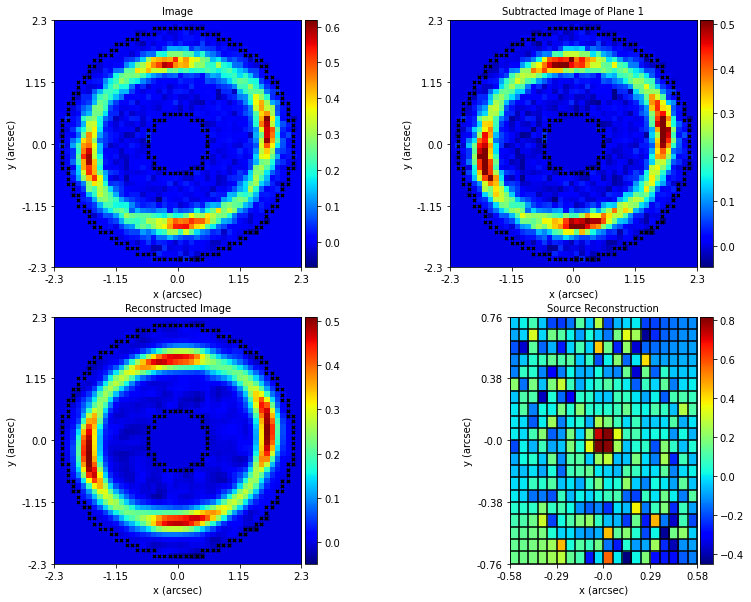

Bayesian Evidence of Incorrect Fit:
2644.012686164661
Bayesian Evidence of Correct Fit:
2731.3654569755313


In [5]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=1.6,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, phi=45.0),
    ),
    shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.05)),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(20, 20)),
    regularization=al.reg.Constant(coefficient=1.0),
)

correct_fit = perform_fit_with_lens__source_galaxy(
    imaging=imaging, lens_galaxy=lens_galaxy, source_galaxy=source_galaxy
)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=correct_fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.subplot_of_planes(plane_index=1)

print("Bayesian Evidence of Incorrect Fit:")
print(fit.log_evidence)
print("Bayesian Evidence of Correct Fit:")
print(correct_fit.log_evidence)

The log evidence *is* lower. However, the difference in log evidence isn't *that large*. This is going to be a problem 
for the non-linear search, as its going to see *a lot* of solutions with really high log evidence value. Furthermore, 
these solutions occupy a *large volumne* of parameter space (e.g. everywhere the lens model that is wrong). This makes 
it easy for the `NonLinearSearch` to get lost searching through these unphysical solutions and, unfortunately, infer an 
incorrect lens model (e.g. a local maxima).

There is no simple fix for this. The reality is that for an `Inversion` these solutions exist. This is how phase 
chaining and pipelines were initially conceived, they offer a simple solution to this problem. We write a pipeline that 
begins by modeling the source galaxy as a `LightProfile`, `initializing` our lens mass model. Then, when we switch to 
an `Inversion` in the next phase, our mass model starts in the correct regions of parameter space and doesn`t get lost 
sampling these incorrect solutions.

Its not ideal, but its also not a big problem. Furthermore, `LightProfile`'ss run faster computationally than 
`Inversion`'s, so breaking down the lens modeling procedure in this way is actually a lot faster than starting with an
`Inversion` anyway!

Okay, so we've covered incorrect solutions, lets end by noting that we can model profiles and inversions at the same 
time. We do this when we want to simultaneously fit and subtract the light of a lens galaxy and reconstruct its lensed 
source using an `Inversion`. To do this, all we have to do is give the lens galaxy a `LightProfile`.

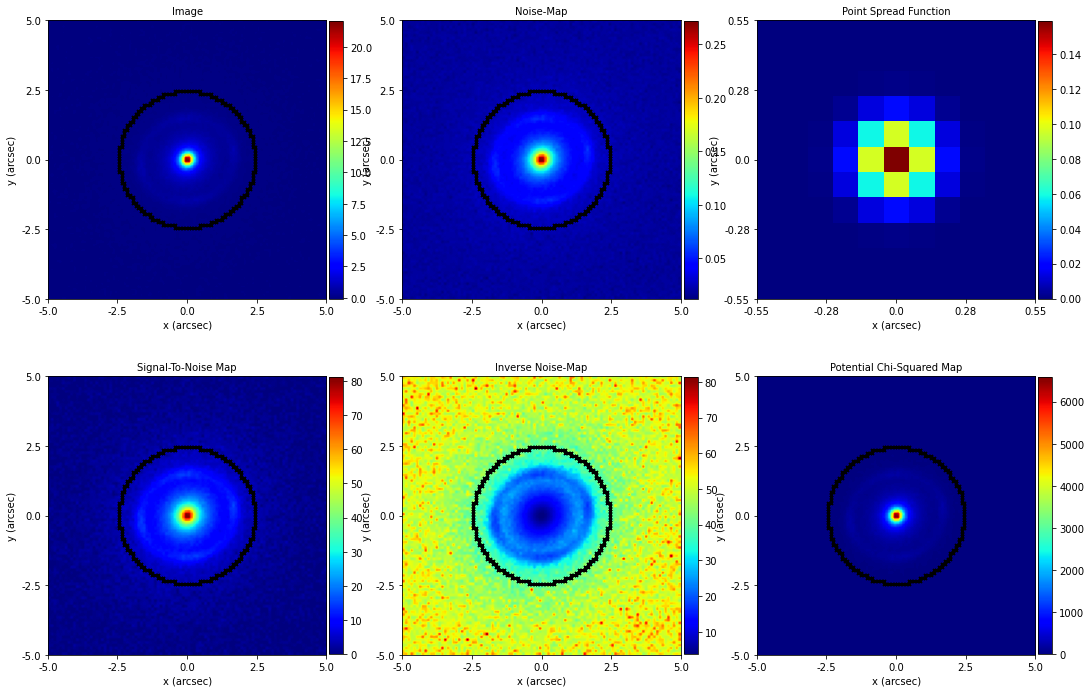

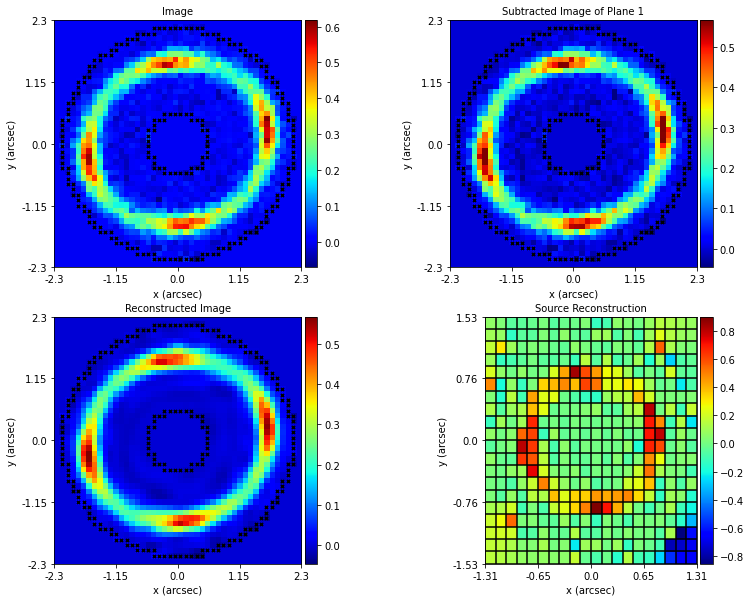

In [6]:
dataset_name = "light_sersic__mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=2.5,
)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_of_planes(plane_index=1)

When fitting such an image we now want to include the lens's light in the analysis. Lets update our mask to be 
circular so that it includes the central regions of the image and lens galaxy.

In [7]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=2.5,
)

As I said above, performing this fit is the same as usual, we just give the lens galaxy a `LightProfile`.

In [8]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    bulge=al.lp.EllipticalSersic(
        centre=(0.0, 0.0),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, phi=45.0),
        intensity=1.0,
        effective_radius=0.8,
        sersic_index=4.0,
    ),
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0), elliptical_comps=(0.1, 0.0), einstein_radius=1.6
    ),
)

These are all the usual things we do when setting up a fit.

In [9]:
source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(20, 20)),
    regularization=al.reg.Constant(coefficient=1.0),
)

masked_imaging = al.MaskedImaging(
    imaging=imaging, mask=mask, settings=al.SettingsMaskedImaging(sub_size=2)
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

This fit now subtracts the lens galaxy's light from the image and fits the resulting source-only image with the 
`Inversion`. When we plot the image, a new panel on the sub-plot appears showing the model image of the lens galaxy.

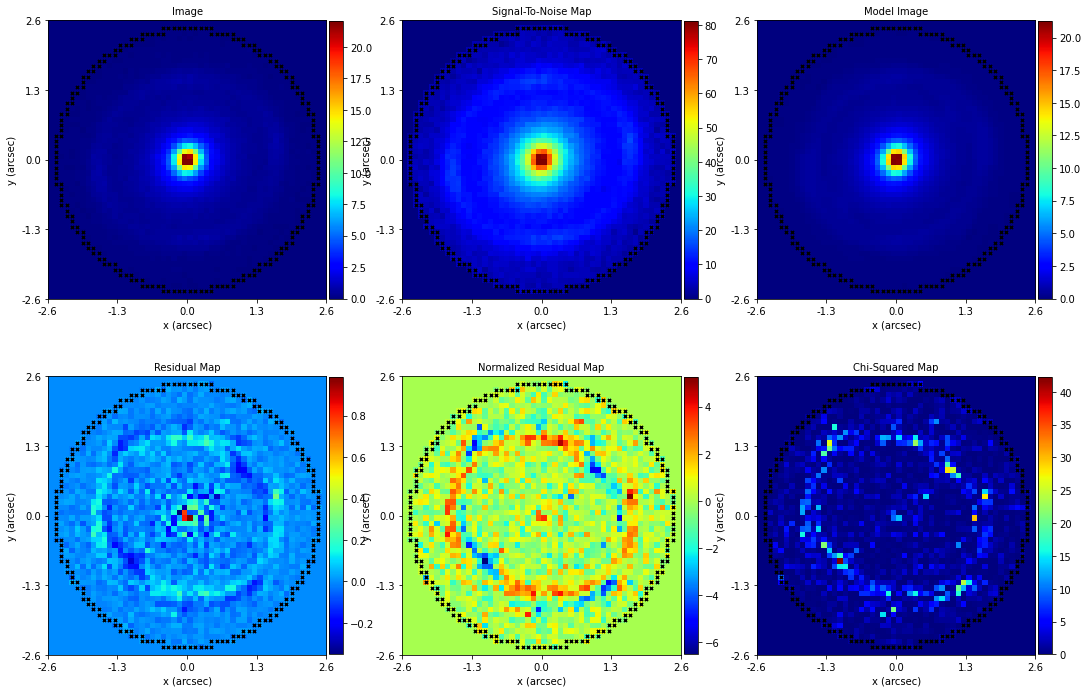

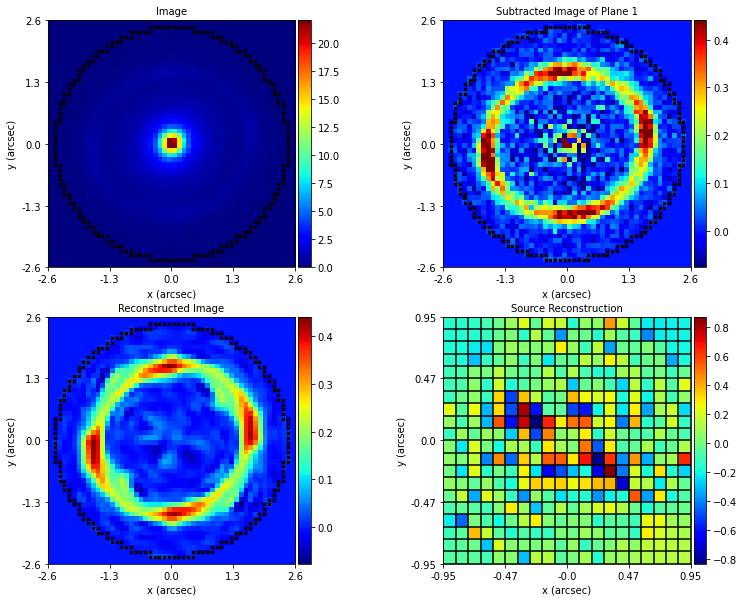

In [10]:
fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

include_2d = aplt.Include2D(mask=True)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.subplot_of_planes(plane_index=1)

Of course if the lens subtraction is rubbish so is our fit, so we can be sure that our lens model wants to fit the 
lens galaxy's light accurately (below, I've increased the lens galaxy intensity from 1.0 to 0.5).

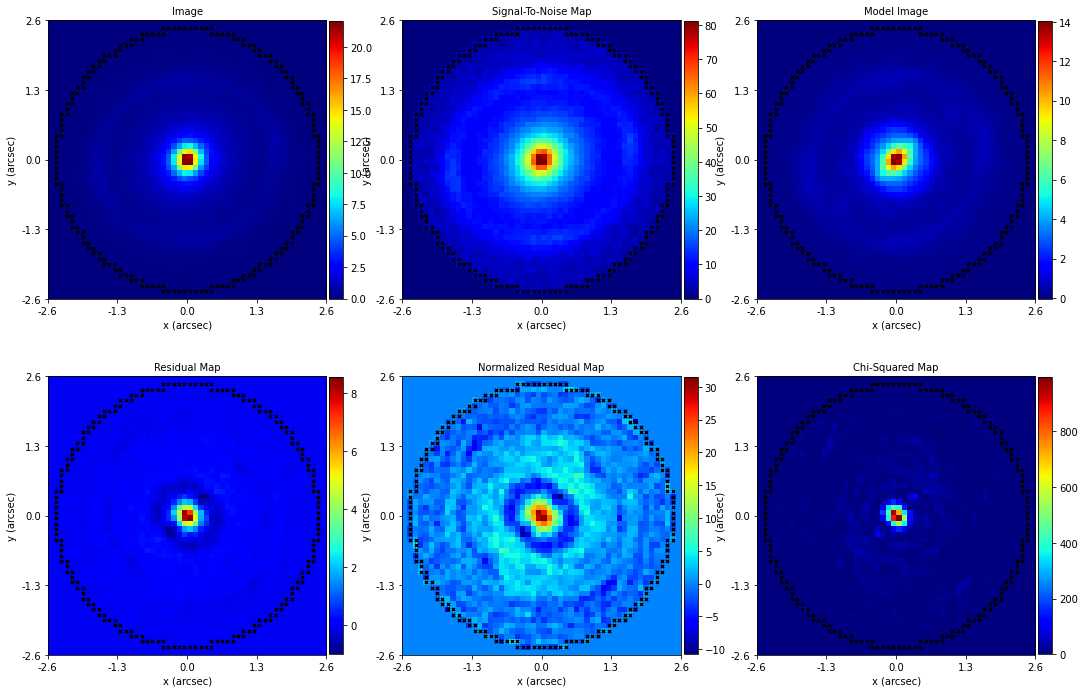

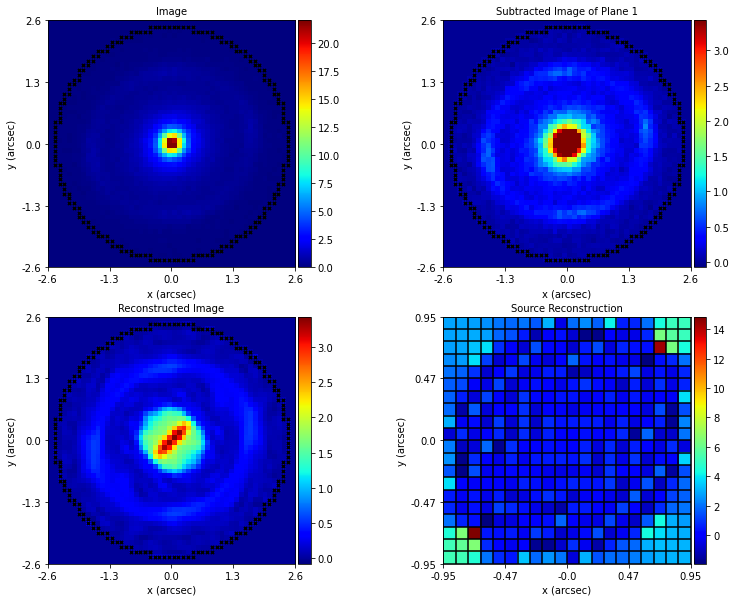

In [11]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    bulge=al.lp.EllipticalSersic(
        centre=(0.0, 0.0),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, phi=45.0),
        intensity=0.5,
        effective_radius=0.8,
        sersic_index=4.0,
    ),
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0), elliptical_comps=(0.1, 0.0), einstein_radius=1.6
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

include_2d = aplt.Include2D(mask=True)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.subplot_of_planes(plane_index=1)

And with that, we're done. Finally, I'll point out a few things about what we've covered to get you thinking about 
the next tutorial on adaption.

 - The unphysical solutions above are clearly problematic. Whilst they have lower Bayesian evidences their existance 
 will still impact our inferred lens model. However, the `Pixelization`'s that we used in this chapter do not 
 adapt to the images they are fitting, meaning the correct solutions achieve much lower Bayesian log evidence 
 values than is actually possible. Thus, once we've covered adaption, these issues will be resolved!
    
 - When the lens galaxy's light is subtracted perfectly it leaves no residuals. However, if it isn't subtracted 
 perfectly it does leave residuals, which will be fitted by the `Inversion`. If the residual are significant this is 
 going to mess with our source reconstruction and can lead to some pretty nasty systematics. In the next chapter, 
 we'll learn how our adaptive analysis can prevent this residual fitting.